# Natural Language Processing Course Project
### Politecnico di Milano, A.Y. 2024/2025

This notebook has been created for the Natural Language Processing course, held by Prof. Carman.

**Authors**:
* Matteo Figini
* Riccardo Figini
* Samuele Forner
* Caterina Motti
* Simone Zacchetti

The purpose of this notebook is to apply different NLP techniques to analyse the **RecipeNLG** dataset, you can find the dataset at the following [link](https://huggingface.co/datasets/mbien/recipe_nlg).

In [1]:
# Import useful libraries
import numpy as np
import pandas as pd
import os
import ast
from collections import defaultdict
import matplotlib.pyplot as plt

# Preliminary analysis

In this section, we aim to perform a preliminary analysis of the dataset.
- Load and inspect the dataset: analyze which field are present, missing field or inconsistencies. 
- Analyze recipe distribution: compute statistics and visualize them.
- Analyze entities distribution: compute statistics and visualize them.

### Load and inspect the dataset

In [2]:
# Load the dataset from CSV file and show its head
df = pd.read_csv("/kaggle/input/recipenlg/dataset/full_dataset.csv")
df

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
2231138,2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",..."
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",cooking.nytimes.com/recipes/1015164,Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l..."


In [3]:
# Show the name of the columns
print("Columns:", df.columns.tolist())

Columns: ['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source', 'NER']


Since the first column has no name, we renamed it:

In [4]:
df = df.rename(columns={'Unnamed: 0': 'Id'})

In [5]:
# Dataset length
print(f"In the dataset there are {len(df)} different recipes!")

In the dataset there are 2231142 different recipes!


As we can see, the dataset contains 2231142 entries in 7 columns:
- id (int): ID.
- title (str): title of the recipe.
- ingredients (list of str): ingredients.
- directions (list of str): instruction steps.
- link (str): URL link.
- source (ClassLabel): origin of each recipe record, with possible value {"Gathered", "Recipes1M"}:
    - "Gathered" (0): additional recipes gathered from multiple cooking web pages using automated scripts in a web scraping process.
    - "Recipes1M" (1): recipes from the "Recipe1M+" dataset.
- NER (list of str): NER food entities.

Now, we check for **inconsistencies** and remove them if needed.

In [6]:
# Rows with missing values
rows_with_null = df.isnull().any(axis=1).sum()
print(f"There are {rows_with_null} rows with at least one null value.")
print(df.isnull().sum())

There are 1 rows with at least one null value.
Id             0
title          1
ingredients    0
directions     0
link           0
source         0
NER            0
dtype: int64


The missing value is a title, which is not a critical field. However, we prefer to remove it.

In [7]:
# Delete rows with at least one missing value
df.dropna()

,Id,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
2231138,2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",..."
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",cooking.nytimes.com/recipes/1015164,Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l..."


In [8]:
# Find duplicates by title
duplicate_counts = df['title'].value_counts()
print("Duplication results by: ", duplicate_counts)

Duplication results by:  title
Chicken Casserole                      4099
Broccoli Casserole                     3985
Squash Casserole                       2508
Cheese Ball                            2426
Zucchini Bread                         2298
                                       ... 
House Slytherin Key Lime Bars             1
Cheesy Loaded Hash Browns Casserole       1
Low Carb Mexican Chicken                  1
Old Fashioned Cocoa                       1
Polpette in Spicy Tomato Sauce            1
Name: count, Length: 1312870, dtype: int64


Here we have lots of duplicates. However, they might represent different variations of the same recipe which could be useful for further analysis.

Since the dataset is really big (2M+ entries), we decided to make a random subsampling of it by retaining only 25% (around half million entries).

In [9]:
# Randomly sample the dataset
df = df.sample(frac=0.25, random_state=42)

### Analyze vocaboulary

In [10]:
# Import necessary libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import bigrams

# Download necessary NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Apply the join operation to each row of the 'directions' column to create a single string
df['directions'] = df['directions'].apply(ast.literal_eval)
df['text'] = df['directions'].apply(lambda steps: ' '.join(steps))

all_instructions_list = [instruction for instructions in df['directions'] for instruction in instructions]

# Preprocess the text and tokenize it into words
full_text = ' '.join(all_instructions_list)
full_text = full_text.lower()
full_text = re.sub(r'[^a-zA-Z0-9\s]', '', full_text)
words = full_text.split()

# Remove stopwords and tokenize
stop_words = set(stopwords.words('english'))
words_nostopwords = [w for w in words if w not in stop_words]
tokens = [w for w in words_nostopwords]

# Generate bigrams and frequency distribution
bigram_list = list(bigrams(tokens))
bigram_fdist = FreqDist(bigram_list)

# Frequency distribution of words
fdist = FreqDist(words_nostopwords)

In [12]:
# Vocabulary size
vocabulary_size = len(fdist)
print("Vocabulary size: ", vocabulary_size)

# Average number of unique words per recipe
unique_words_per_recipe = []

for directions in df['text']:
    directions = directions.lower()
    directions = re.sub(r'[^a-zA-Z0-9\s]', '', directions)  # remove punctuation
    tokens = directions.split()  # split into words
    tokens = [w for w in tokens if w not in stop_words]
    unique_words = set(tokens)
    unique_words_per_recipe.append(len(unique_words))

avg_unique_words_per_recipe = sum(unique_words_per_recipe) / len(unique_words_per_recipe)    
print("Average number of unique words per recipe: ", avg_unique_words_per_recipe)

# Compute word length distribution
word_lengths = [len(word) for word in words_nostopwords]
avg_word_length = sum(word_lengths) / len(word_lengths)
min_word_length = min(word_lengths)
max_word_length = max(word_lengths)

print("Average word length: ", avg_word_length, " characters")
print("Minimum word length: ", min_word_length, " characters")
print("Maximum word length: ", max_word_length, " characters")

Vocabulary size:  112018
Average number of unique words per recipe:  43.36856787370067
Average word length:  5.285405950756063  characters
Minimum word length:  1  characters
Maximum word length:  262  characters


The high vocabulary size shows that the dataset is very rich and diverse, covering many ingredients, actions, and contextual descriptions. 

However the average number of unique words in each recipe is quite small: this suggests that each recipe tends to use a fairly concise and domain-specific subset.

NB: the maximum word length (262 characters) is likely an outlier. We must investigate it further. 

In [13]:
# Find the longest words
def find_long_words_in_directions(df):
    long_words = []
    
    for directions in df['text']:
        # Extract words longer than 45 characters, since in English vocabulary the longest word has 45 characters
        long_words.extend([word for word in directions.split() if len(word) > 45])
    
    if long_words:
        print("Found ", len(long_words), " long words in the dataset (greater than 45 characters):")
        for word in long_words:
            print(word)
    else:
        print("No words longer than 45 characters found.")

find_long_words_in_directions(df)

Found  620  long words in the dataset (greater than 45 characters):
https://food52.com/blog/3601-how-to-temper-chocolate
http://www.discountqueens.com/homemade-dry-onion-soup-mix/.
http://www.bonappetit.com/recipes/2012/04/nonna-consuelos-bolognese-sauce#ixzz1s9eVVHNG
http://leitesculinaria.com/99229/recipes-cinnamon-granola-bars.html#o3BvUmhKMCExxhX8.99
(http://www.ehow.com/how_4731920_temper-an-egg.html).
https://cookpad.com/en/recipes/156069-kimchi-and-egg-rice-bowl-and-oyako-don-with-tinned-yakitori-chicken
https://cookpad.com/en/recipes/151167-sweet-savory-pork-rice-bowl
http://www.kitchenriffs.com/2013/06/the-dark-and-stormy-cocktail.html.
http://alldayidreamaboutfood.com/2012/04/maple-pecan-scones-low-carb-and-gluten-free.html
http://www.lowcarbmaven.com/easyrecipe-print/10109-0
http://starbucksrestaurantathome.blogspot.com/2012/12/maple-oat-nut-scones.html
http://thepioneerwoman.com/cooking/maple-oat-nut-scones/?printable_recipe=11466
http://theviewfromgreatisland.com/maple-oat

Most of them are links, so we can keep them (also considering that they are not that frequent).

In [14]:
# Create frequency distribution for bigrams
bigram_fdist = FreqDist(bigram_list)

# Display top 10 most common words
print("\nTop 10 most common words:")
for word, freq in fdist.most_common(10):
    print(f"{word}: {freq}")

# Display top 10 most common bigrams
print("\nTop 10 most common bigrams:")
for bigram, freq in bigram_fdist.most_common(10):
    print(f"{' '.join(bigram)}: {freq}")



Top 10 most common words:
add: 681360
minutes: 598142
heat: 396857
mix: 310106
cook: 277251
bowl: 275700
pan: 274190
stir: 272397
mixture: 272239
1: 265148

Top 10 most common bigrams:
salt pepper: 92694
preheat oven: 83194
5 minutes: 72573
10 minutes: 70488
set aside: 70229
medium heat: 62024
large bowl: 61419
30 minutes: 57096
olive oil: 52748
15 minutes: 52534


### Analyze recipes distribution
Since the recipes are the core of the dataset, it may be useful to analyse the length of each recipe to plot their distribution.

Recipes with very high or very low word counts might be outliers. Analyzing the distribution allows us to detect these outliers, which might skew our analysis. For instance, a recipe with only one word might be a mistake.

In [15]:
# Define a new column to count the number of words in 'directions'
df['dir_word_count'] = df['directions'].apply(lambda x: len(' '.join(x).split()))

# Print the new column with word counts
print(df[['directions', 'dir_word_count']])

                                                directions  dir_word_count
2015528  [Remove tenderloin from steak., Score meat., C...              31
1608734  [combine all ingredients in slow cooker (6 qua...             122
778500   [Cook 3 to 4 carrots; cut crosswise in 1-inch ...              38
1334975  [Mix all dry ingredients in a bowl., , Add cri...              44
116562   [Mix and press in baking pan, approximately 13...              16
...                                                    ...             ...
66686    [Whip cream cheese until soft and fluffy., Bea...              57
2014459  [In Dutch oven., heat oil: stir in onion, cele...              75
981506   [Pour the milk into the crock pot and turn it ...             202
1503162  [Preheat broiler. In a large skillet, cook and...              85
207060   [Combine all ingredients, except vegetable coo...              30

[557786 rows x 2 columns]


In [16]:
# Retrieve the length and index of the longest and shortest recipe
max_words = df['dir_word_count'].max()
min_words = df['dir_word_count'].min()

max_words_idx = df['dir_word_count'].idxmax()
min_words_idx = df['dir_word_count'].idxmin()
print(f"Recipes' direction have between {min_words} and {max_words} words.")
print(f"The longest recipe has {max_words} words and it stands at location {max_words_idx}.")
#print(df['directions'].loc[max_words_idx])
print(df[['title','directions', 'dir_word_count']].loc[min_words_idx])

Recipes' direction have between 1 and 2649 words.
The longest recipe has 2649 words and it stands at location 1717085.
title             Kale Apple Love
directions                [Juice]
dir_word_count                  1
Name: 2081257, dtype: object


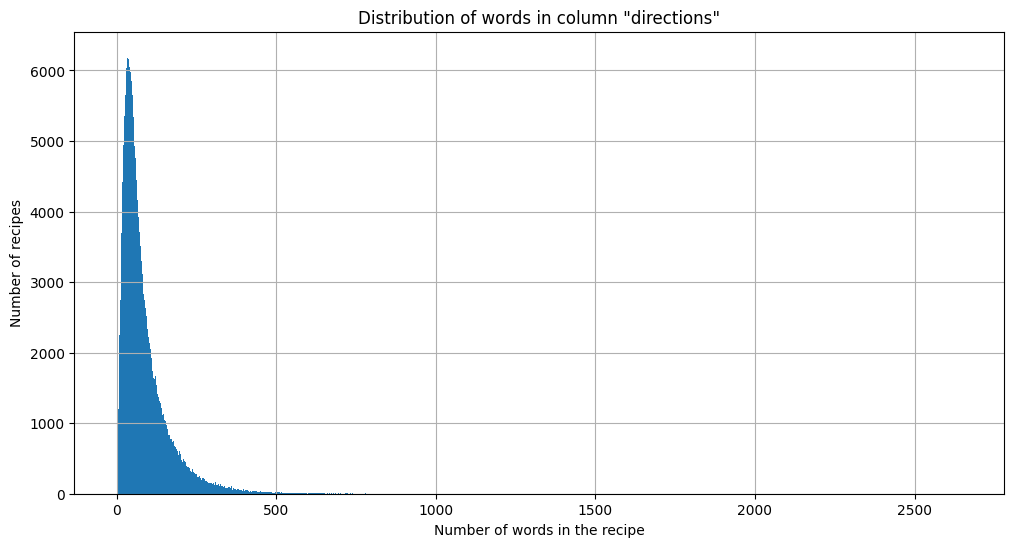

In [17]:
# Visualize the distribution of the number of words in column "directions" to show how long recipes are (in number of words)
plt.figure(figsize=(12,6))
plt.hist(df['dir_word_count'], bins=max_words, range=(0, max_words))
plt.title('Distribution of words in column \"directions\"')
plt.xlabel('Number of words in the recipe')
plt.ylabel('Number of recipes')
plt.grid(True)
plt.show()

In [18]:
# Analyzing recipe word count distribution
word_counts = df['dir_word_count'].dropna()
mean_word_count = word_counts.mean()
median_word_count = word_counts.median()
percentile_90 = word_counts.quantile(0.9)
percentile_95 = word_counts.quantile(0.95)

print(f"Mean word count: {mean_word_count}")
print(f"Median word count: {median_word_count}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

Mean word count: 85.8118256822509
Median word count: 61.0
90th percentile: 179.0
95th percentile: 237.0


In [19]:
# Count recipes with less than upper_threshold words
upper_threshold = 300
count_less_threshold = (word_counts <= upper_threshold).sum()

upper_percentage = count_less_threshold/len(df) * 100

print(f"{round(upper_percentage, 2)}% of the recipes have at most {upper_threshold} words.")

97.55% of the recipes have at most 300 words.


In [20]:
# Count recipes with more than lower_threshold words
lower_threshold = 20
count_more_threshold = (word_counts >= lower_threshold).sum()

lower_percentage = count_more_threshold/len(df) * 100

print(f"{round(lower_percentage, 2)}% of the recipes have at least {lower_threshold} words.")

91.69% of the recipes have at least 20 words.


### Analyze entities distribution
The aim of this section is to analyse the number of elements in the NER column, which contains the number of entities in each recipe, and to provide a distribution, giving a rough measure of the "complexity" of the recipe.

In [21]:
# Define a new column containing the number of entities of each recipe
ner_column = 'ner_len'

df[ner_column] = df['NER'].apply(lambda x: len(ast.literal_eval(x)))
print(df[ner_column])

2015528    10
1608734    17
778500      4
1334975     8
116562      2
           ..
66686       6
2014459    10
981506      3
1503162    15
207060     10
Name: ner_len, Length: 557786, dtype: int64


In [22]:
# Retrieve the length and index of recipe with highest and lowest NER number
max_ner_len = df[ner_column].max()
min_ner_len = df[ner_column].min()

max_ner_len_idx = df[ner_column].idxmax()
print(f"Recipes have between {min_ner_len} and {max_ner_len} entities.")

print(f"The longest recipe has {max_ner_len} words and it is at location {max_ner_len_idx}.")
#print(df['NER'].loc[max_ner_len_idx])

Recipes have between 0 and 402 entities.
The longest recipe has 402 words and it is at location 719239.


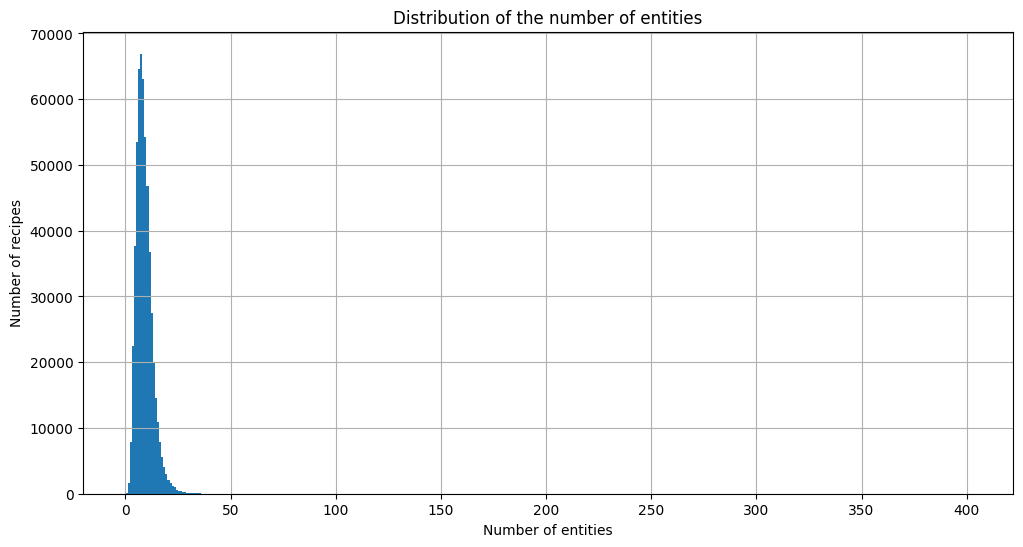

In [23]:
# Visualize the number of entities in each recipe
plt.figure(figsize=(12,6))
plt.hist(df[ner_column], bins=max_ner_len, range=(0, max_ner_len))
plt.title('Distribution of the number of entities')
plt.xlabel('Number of entities')
plt.ylabel('Number of recipes')
plt.grid(True)
plt.show()

In [24]:
# Analyzing recipe NER count distribution
entities_counts = df[ner_column].dropna()
mean_entities_count = entities_counts.mean()
median_entities_count = entities_counts.median()
percentile_90 = entities_counts.quantile(0.9)
percentile_95 = entities_counts.quantile(0.95)

print(f"Mean NER count: {mean_entities_count}")
print(f"Median NER count: {median_entities_count}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

Mean NER count: 8.482846468000272
Median NER count: 8.0
90th percentile: 13.0
95th percentile: 16.0


In [25]:
# Count recipes with less than upper_threshold entities
upper_threshold = 25
count_less_threshold = (entities_counts <= upper_threshold).sum()

upper_percentage = count_less_threshold/len(df) * 100

print(f"{round(upper_percentage, 2)}% of the recipes have at most {upper_threshold} entities.")

99.72% of the recipes have at most 25 entities.


In [26]:
# Count recipes with more than lower_threshold entities
lower_threshold = 3
count_more_threshold = (entities_counts >= lower_threshold).sum()

lower_percentage = count_more_threshold/len(df) * 100

print(f"{round(lower_percentage, 2)}% of the recipes have at least {lower_threshold} entities.")

98.27% of the recipes have at least 3 entities.


In [27]:
# Filter recipes where there are NO NER
zero_NER_recipes = df[df['ner_len'] == 0]

print(zero_NER_recipes[['title', 'NER']])
# Drop recipes where there are no NERs
df = df[df['ner_len'] != 0]

                                                     title NER
1795606                                        Aromatic Fu  []
2099220                                  Roasting Squashes  []
2134230                               Biscuit Pocket Bread  []
1342271                                       Duck Breast   []
1821196                                     Baby Back Ribs  []
...                                                    ...  ..
1337658  Spaghetti With Olives, Dried Chillies And Pang...  []
407311                                        Unfried Pies  []
1383058            Traditional Armenian Dish - Lamb Recipe  []
1735481                                          Asparagus  []
1285166  Cauliflower  Broccoli Dish With Bacon And Che...  []

[128 rows x 2 columns]


It means that the NER process didn't detect any entities for these recipes. This could happen for various reasons, such as:
- The recipe doesn't contain recognizable entities like ingredients, amounts, or special terms.
- The NER process might not be comprehensive enough to detect all relevant entities in the recipe.
- The recipe could be incomplete or malformed in a way that prevents proper entity recognition.

For this reason, we decided to drop these rows.

NB: It may happens that there are NO entries without NER, since we are using a subsample of the original dataset. 

## Clustering

Now we want to perform some clustering analysis.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

In [ ]:
inertia = []
k_values = list(range(2, 50))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Metodo del gomito per determinare k')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Inerzia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

It seems that two interesting values for K are 13 and 21, let's try both of them.

In [ ]:
n_clusters = 13
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(X)

# Add clusters to the original dataframe
df['cluster'] = kmeans.labels_

# Print an example of titles grouped by cluster
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))

In [ ]:
# Get the centroid for the first cluster
centroid = kmeans.cluster_centers_[0]

# Sort terms according to their weights
# (argsort goes from lowest to highest, we reverse the order through slicing)
sorted_terms = centroid.argsort()[::-1]

# Print out the top 10 terms for the cluster
[titles[j] for j in sorted_terms[:20]]

In [ ]:
n_clusters = 21
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(X)

df['cluster'] = kmeans.labels_

for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))

In [ ]:
centroid = kmeans.cluster_centers_[0]

sorted_terms = centroid.argsort()[::-1]

[titles[j] for j in sorted_terms[:20]]

In [ ]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

In [ ]:
print('Number of docs in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

### Evaluation

In order to evaluate our clustering we are using only intrinsic method, since we do not have the real labels of the clusters.

In [ ]:
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
#print("Silhouette coefficient:", str(metrics.silhouette_score(X, kmeans.labels_)))

Since the dataset is quite big, even reducing it to a quarter of the original, we try to perform also a Mini Batch Clustering.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = 21
mb_kmeans = MiniBatchKMeans(n_clusters=n_clusters,batch_size=500, random_state=2307)
mb_kmeans.fit(X)

In [ ]:
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(mb_kmeans.inertia_))
#print("Silhouette coefficient:", str(metrics.silhouette_score(X, mb_kmeans.labels_)))

Now, let's try to visualize clusters.

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(X)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=kmeans.labels_, marker='.')

## Indexing

In [ ]:
!pip install -q python-terrier==0.11.0

In [ ]:
import pyterrier as pt

if not pt.started():
  pt.init()

**Index by ingredients**

In [ ]:
import ast

def ingrs_to_list_str(list_):
    list_of_string = []
    for item in list_:
        toStr = ' '.join(ast.literal_eval(item))
        list_of_string.append(toStr)
    return list_of_string

colSeries = df['ingredients']
ingredients_list = ingrs_to_list_str(colSeries)

toEx = ingredients_list[:10]

for i in toEx:
    print(f"\n\n {i}")



 1 1/2 pound flank steak 1/2 c. finely minced green onions (scallions) 1/2 c. dry red wine 1/4 c. soy sauce 3 tbsp. salad oil 3 teaspoon sesame seeds 2 teaspoon packed brown sugar 1/4 teaspoon grnd black pepper 1/4 teaspoon grnd ginger 1 clove garlic, chopped


 1 tablespoon rosemary 1 teaspoon thyme 3 bay leaves 1 teaspoon smoked paprika 1 teaspoon pepper 1/4 cup red wine 3 cups chicken broth 2 cups button mushrooms sliced 2 cups mushroom mix, oyster, shiitake, baby bella, sliced 2 medium carrots sliced diagonally 1 onion medium, chopped 1 red potato medium, cut in 1-inch pieces 1 cup frozen green beans 1-inch pieces 1/2 can black olives pitted ripe, halved 1 handful grape tomatoes halved 8 chicken thighs with bones and skin. 2-3 lbs 2 stalks celery 3 cups water


 3 to 4 carrots 1 1/2 Tbsp. butter 1/3 c. brown sugar grated lemon rind and juice


 4.5 Cups Flour 1.5 Tsp Salt Pinch Baking Powder 1 Tbls Sugar 1 2/3 cup Crisco 1 egg lightly beaten 1 tsp vinegar Ice Water


 2 c. crushe

In [ ]:
documents = [{'docno': str(i), 'text': text} for i, text in enumerate(ingredients_list)]
indexer = pt.IterDictIndexer("./index", overwrite=True)
indexer.index(documents)

21:03:32.500 [ForkJoinPool-4-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (159129) - further warnings are suppressed
21:04:15.191 [ForkJoinPool-4-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 7 empty documents


<org.terrier.querying.IndexRef at 0x796bc8b7c890 jclass=org/terrier/querying/IndexRef jself=<LocalRef obj=0x2f21ebe8 at 0x796be17ed9f0>>

In [ ]:
index = pt.IndexFactory.of("./index")

# Classic index
bm25 = pt.terrier.Retriever(index, wmodel="BM25")
tfidf = pt.terrier.Retriever(index, wmodel="TF_IDF")

# Specialized index for this contex

# In this case the repetition doesn't count
dfree = pt.terrier.Retriever(index, wmodel="DFRee")
# k1=0 force BM25 to ignore term frequency and only count matches.
bm25_no_tf = pt.terrier.Retriever(index, wmodel="BM25", controls={"k_1": "0.0", "b": "0.0"})


In [ ]:
print(index.getCollectionStatistics().toString())

Number of documents: 557658
Number of terms: 29085
Number of postings: 14945695
Number of fields: 1
Number of tokens: 22660675
Field names: [text]
Positions:   false



In [ ]:
# Some queries 

queries = [
    {"qid": "1", "query": "chicken"},
    {"qid": "2", "query": "tomato basil"},
    {"qid": "3", "query": "rice chicken onion"},
    {"qid": "4", "query": "beef onion garlic pepper"},
    {"qid": "5", "query": "salmon lemon dill butter"},
    {"qid": "6", "query": "pasta olive oil garlic cheese"},
    {"qid": "7", "query": "mushrooms cream parmesan thyme"},
    {"qid": "8", "query": "potatoes butter rosemary salt"},
    {"qid": "9", "query": "tuna celery mayonnaise pickle"},
    {"qid": "10", "query": "zucchini olive oil pepper onion"},
    {"qid": "11", "query": "apple cinnamon sugar flour"},
    {"qid": "12", "query": "banana oats honey peanut butter"},
    {"qid": "13", "query": "chocolate butter flour eggs sugar"},
    {"qid": "14", "query": "shrimp garlic lemon parsley"},
    {"qid": "15", "query": "broccoli cheese cream garlic"},
]

In [ ]:
for i, q in enumerate(queries):
    if i%2==0:
        print(bcolors.OKGREEN)
    else:
        print(bcolors.OKBLUE)
    
    result_bm25 = bm25.search(q['query'])
    result_tfidf = tfidf.search(q['query'])
    result_dfree = dfree.search(q['query'])
    result_bm25_no_tf = bm25_no_tf.search(q['query'])

    print(result_bm25)
    print(result_tfidf)
    print(result_dfree)
    print(result_bm25_no_tf)



    qid   docid   docno  rank     score    query
0     1   21793   21793     0  5.089820  chicken
1     1  213014  213014     1  5.069910  chicken
2     1  113411  113411     2  5.034422  chicken
3     1  226140  226140     3  5.010803  chicken
4     1  545842  545842     4  5.010803  chicken
..   ..     ...     ...   ...       ...      ...
995   1  298145  298145   995  4.401338  chicken
996   1  345964  345964   996  4.401338  chicken
997   1  350860  350860   997  4.401338  chicken
998   1  352596  352596   998  4.401338  chicken
999   1  384829  384829   999  4.401338  chicken

[1000 rows x 6 columns]
    qid   docid   docno  rank     score    query
0     1   21793   21793     0  3.179007  chicken
1     1  213014  213014     1  3.166571  chicken
2     1  113411  113411     2  3.144406  chicken
3     1  226140  226140     3  3.129654  chicken
4     1  545842  545842     4  3.129654  chicken
..   ..     ...     ...   ...       ...      ...
995   1  298145  298145   995  2.748993  ch

In [ ]:
titles = df['title']

for i, q in enumerate(queries):
    print(f"\n=== QUERY {i+1}: {q} ===")

    result_bm25 = bm25.search(q['query'])
    result_tfidf = tfidf.search(q['query'])
    result_dfree = dfree.search(q['query'])
    result_bm25_no_tf = bm25_no_tf.search(q['query'])

    for method_name, result in [
        ("BM25", result_bm25),
        ("TF-IDF", result_tfidf),
        ("DFRee", result_dfree),
        ("BM25_no_tf", result_bm25_no_tf),
    ]:
        print(f"\n--- MODELLO: {method_name} ---")
        
        # Limita i risultati a massimo 5
        for docno in result["docno"][:5]:  # <-- TAGLIA qui i risultati
            docno_int = int(docno)  # forza conversione str -> int
            title = titles.iloc[docno_int] if docno_int < len(titles) else "TITLE NOT FOUND"
            print(f"Docno: {docno} | Title: {title}")




=== QUERY 1: {'qid': '1', 'query': 'chicken'} ===

--- MODELLO: BM25 ---
Docno: 21793 | Title: Cheesy Bacon Chicken
Docno: 213014 | Title: Baked Chicken Recipe
Docno: 113411 | Title: Perfect Roast Chicken Recipe
Docno: 226140 | Title: Chicken Pie
Docno: 545842 | Title: Chicken Casserole

--- MODELLO: TF-IDF ---
Docno: 21793 | Title: Cheesy Bacon Chicken
Docno: 213014 | Title: Baked Chicken Recipe
Docno: 113411 | Title: Perfect Roast Chicken Recipe
Docno: 226140 | Title: Chicken Pie
Docno: 545842 | Title: Chicken Casserole

--- MODELLO: DFRee ---
Docno: 551102 | Title: Chicken Pot Pie(350~ Oven)  
Docno: 337182 | Title: Chicken And Dumplings
Docno: 389820 | Title: Chicken Casserole
Docno: 554398 | Title: Chicken Dumpling Casserole
Docno: 112653 | Title: Napoleon Chicken

--- MODELLO: BM25_no_tf ---
Docno: 21793 | Title: Cheesy Bacon Chicken
Docno: 213014 | Title: Baked Chicken Recipe
Docno: 113411 | Title: Perfect Roast Chicken Recipe
Docno: 226140 | Title: Chicken Pie
Docno: 545842 | 

Consideration:

The retrieval results are overall very good.
- BM25, TF-IDF, and BM25_no_tf consistently retrieved highly relevant recipes, especially when queries matched common ingredients.
- DFRee performed slightly more varied but still reasonable, it differnts a little bit from the other

There is strong consistency between BM25 and TF-IDF, especially for simple queries.
In general, the indexing and retrieval setup works well for recipe search based on ingredients.

**Index by title**

In [ ]:
coltitle = df['title'].tolist()

toEx = coltitle[3000:3010]

for i in toEx:
    print(f"\n\n {i}")



 Calico Salad


 Tofu Herb Spread


 Egg Salad With A Twist


 Pork Braised In Milk And Cream Recipe


 Gluten Free Rosemary Bread 


 Hawaiian Grilled Pork Chops


 Easy Christmas Cupcake Decorations


 Bibimbap/Rice Mixed With Vegetables And Beef 


 Deluxe Peas


 Donna B's Meatballs


In [ ]:
documents = [{'docno': str(i), 'text': text} for i, text in enumerate(coltitle)]
indexer = pt.IterDictIndexer("./index_title", overwrite=True)
indexer.index(documents)

21:05:44.323 [ForkJoinPool-7-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (194) - further warnings are suppressed
21:06:05.281 [ForkJoinPool-7-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 46 empty documents


<org.terrier.querying.IndexRef at 0x796be30df110 jclass=org/terrier/querying/IndexRef jself=<LocalRef obj=0x2f21e4f0 at 0x796be1bbb950>>

In [ ]:
index = pt.IndexFactory.of("./index_title")

# Classic index
bm25 = pt.terrier.Retriever(index, wmodel="BM25")
tfidf = pt.terrier.Retriever(index, wmodel="TF_IDF")

# Specialized index for this contex
dfree = pt.terrier.Retriever(index, wmodel="DFRee")
bm25_no_tf = pt.terrier.Retriever(index, wmodel="BM25", controls={"k_1": "0.0", "b": "0.0"})

In [ ]:
print(index.getCollectionStatistics().toString())

Number of documents: 557658
Number of terms: 34052
Number of postings: 1858185
Number of fields: 1
Number of tokens: 1866522
Field names: [text]
Positions:   false



In [ ]:
# Some queries 

queries = [
    {"qid": "1", "query": "chicken"},
    {"qid": "2", "query": "tomato"},
    {"qid": "3", "query": "rice"},
    {"qid": "4", "query": "beef"},
    {"qid": "5", "query": "salmon lemon"},
    {"qid": "6", "query": "pasta"},
    {"qid": "7", "query": "Cornmeal Rolls"},
    {"qid": "8", "query": "Meatballs"},
    {"qid": "9", "query": "tuna celery mayonnaise pickle"},
    {"qid": "10", "query": "Cupcake"},
    {"qid": "11", "query": "Fettuccine"},
    {"qid": "12", "query": "banana"},
    {"qid": "13", "query": "Spiced Wieners"},
    {"qid": "14", "query": "Cookies"},
    {"qid": "15", "query": "Hamburger And Potatoes"},
]

In [ ]:
for i, q in enumerate(queries):
    if i%2==0:
        print(bcolors.OKGREEN)
    else:
        print(bcolors.OKBLUE)
    
    result_bm25 = bm25.search(q['query'])
    result_tfidf = tfidf.search(q['query'])
    result_dfree = dfree.search(q['query'])
    result_bm25_no_tf = bm25_no_tf.search(q['query'])

    print(result_bm25)
    print(result_tfidf)
    print(result_dfree)
    print(result_bm25_no_tf)


    qid   docid   docno  rank     score    query
0     1    6952    6952     0  5.021262  chicken
1     1    6986    6986     1  5.021262  chicken
2     1  231410  231410     2  5.021262  chicken
3     1  245792  245792     3  5.021262  chicken
4     1  345320  345320     4  5.021262  chicken
..   ..     ...     ...   ...       ...      ...
995   1   59654   59654   995  4.244088  chicken
996   1   59681   59681   996  4.244088  chicken
997   1   59692   59692   997  4.244088  chicken
998   1   59740   59740   998  4.244088  chicken
999   1   59815   59815   999  4.244088  chicken

[1000 rows x 6 columns]
    qid   docid   docno  rank     score    query
0     1    6952    6952     0  2.915111  chicken
1     1    6986    6986     1  2.915111  chicken
2     1  231410  231410     2  2.915111  chicken
3     1  245792  245792     3  2.915111  chicken
4     1  345320  345320     4  2.915111  chicken
..   ..     ...     ...   ...       ...      ...
995   1   59654   59654   995  2.463920  ch

In [ ]:
titles = df['title']

for i, q in enumerate(queries):
    print(f"\n=== QUERY {i+1}: {q} ===")

    result_bm25 = bm25.search(q['query'])
    result_tfidf = tfidf.search(q['query'])
    result_dfree = dfree.search(q['query'])
    result_bm25_no_tf = bm25_no_tf.search(q['query'])

    for method_name, result in [
        ("BM25", result_bm25),
        ("TF-IDF", result_tfidf),
        ("DFRee", result_dfree),
        ("BM25_no_tf", result_bm25_no_tf),
    ]:
        print(f"\n--- MODELLO: {method_name} ---")
        
        # Limita i risultati a massimo 5
        for docno in result["docno"][:5]:  # <-- TAGLIA qui i risultati
            docno_int = int(docno)  # forza conversione str -> int
            title = titles.iloc[docno_int] if docno_int < len(titles) else "TITLE NOT FOUND"
            print(f"Docno: {docno} | Title: {title}")


=== QUERY 1: {'qid': '1', 'query': 'chicken'} ===

--- MODELLO: BM25 ---
Docno: 6952 | Title: Chicken Fried Chicken
Docno: 6986 | Title: Chicken With  Chicken With Lemon 
Docno: 231410 | Title: City Chicken (But It'S Not Chicken!)
Docno: 245792 | Title: Chicken Fried Chicken
Docno: 345320 | Title: Chicken Casserole With No Chicken

--- MODELLO: TF-IDF ---
Docno: 6952 | Title: Chicken Fried Chicken
Docno: 6986 | Title: Chicken With  Chicken With Lemon 
Docno: 231410 | Title: City Chicken (But It'S Not Chicken!)
Docno: 245792 | Title: Chicken Fried Chicken
Docno: 345320 | Title: Chicken Casserole With No Chicken

--- MODELLO: DFRee ---
Docno: 53975 | Title: Popeye Tso'S Chicken (General Tso'S Chicken Made With Popeye'S Chicken Nuggets) Recipe
Docno: 336299 | Title: Brandied Tarragon Cream Chicken (Chicken a la Vallee d'Auge), Camembert Rice with Warm Endive and Apples
Docno: 279696 | Title: Indian Green Bell Pepper And Chicken Curry: Home Style Chicken Jalfrezi
Docno: 2138 | Title: New 

The retrieval results are generally very good and consistent across models.

Possible implementation:
- merging searches by title and ingredients
- Inclusion of ingredients on hand and second check that they are indeed all present in those extracted
  

## Word2Vec

First thing first, we need a list

In [ ]:
w2v_directions = list(df['text'])

['Remove tenderloin from steak. Score meat. Combine remaining ingredients and pour over meat. Let marinate 24 hrs. Preheat grill. Broil or possibly grill. Slice thinly on an angle against the grain.', "combine all ingredients in slow cooker (6 quarts). bury chicken in vegetables. don't put herbs directly on chicken (because skin is removed later) add enough broth and water to cover most of ingredients. liquid level rises a good amount during cooking, so careful with filling the slow cooker too much. turn slow cooker on low for 6-7 hours or high 3-4 hours. Note: in my newer Crock-Pot this was enough time, but in my parents' older Crock-Pot 7 hours on low was not enough (don't know how long would be good. we left the veggies a little tough). pull out all chicken. skim off fat from top with spoon pull off skin and remove bones from chicken. shred and return to soup.", 'Cook 3 to 4 carrots; cut crosswise in 1-inch pieces. Add butter, brown sugar (packed) and grated lemon rind and juice to 

Let's reduce the size of the data

In [ ]:
print(len(w2v_directions))

subset_size = len(w2v_directions)// 10

subset_directions = random.sample(w2v_directions, subset_size)

print(len(subset_directions))

557658
55765


Now let's tokenize each remaining direction to have the right format for our World2Vec model



In [ ]:
tokenized_directions = [re.sub('\W', ' ', direction).lower().split() for direction in subset_directions]

Let's remove the stopwords
(we need a context window to train it, so we are discarding the directions composed by only one word)

In [ ]:
filtered_directions = [[word for word in sublist if word not in stop_words] for sublist in tokenized_directions]

filtered_directions = [direction for direction in filtered_directions if len(direction) > 1]

print(len(filtered_directions))

55757


Now it's time to  train our model!


In [ ]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(filtered_directions, vector_size=50, min_count=5, window=10)

len(model.wv)

7215

Ever wondered what is a possible vector representation of the word soup?  Me neither!

In [ ]:
term = 'soup'
model.wv[term]

array([ 2.9419484e+00, -1.4611880e-01, -3.9913628e+00,  1.6946219e+00,
        6.2145382e-02,  2.0096855e+00, -2.0518308e+00, -4.5211334e+00,
       -4.7528321e-01,  1.0102936e+00,  2.6131551e+00, -1.0602553e+00,
       -1.7551796e+00,  5.9171003e-01,  4.7172194e+00,  2.4775479e+00,
        6.0031452e+00,  7.4741524e-01,  1.8890111e+00,  5.4919662e+00,
       -4.0797383e-01,  5.7767744e+00, -1.7145067e+00, -2.0798598e-01,
       -6.1538496e+00,  1.1580485e+00,  9.3807036e-01,  2.1436152e+00,
        5.3112254e+00,  2.0793598e+00, -2.2071002e-03, -2.3820827e+00,
       -3.5474019e+00, -1.8219496e+00,  2.3921337e+00,  3.6322272e-01,
       -9.3868881e-01,  5.6189299e+00,  1.6782244e-01,  4.9859950e-01,
        2.7930076e+00,  5.4128963e-01,  6.0236138e-01, -3.2531217e-01,
        2.9640546e+00,  5.1110715e-02, -1.3570150e+00, -8.1334567e-01,
        1.8984419e+00, -2.3965597e+00], dtype=float32)

Or what are the most similar words to 'chicken' (Between the ones in our dataset)

In [ ]:
term = 'chicken'

model.wv.most_similar(term)

[('breasts', 0.767844021320343),
 ('turkey', 0.6270121932029724),
 ('vegetables', 0.6247648000717163),
 ('thighs', 0.6112908720970154),
 ('wings', 0.6064701080322266),
 ('steak', 0.592051088809967),
 ('mushrooms', 0.591825008392334),
 ('mushroom', 0.5890988707542419),
 ('meat', 0.5773897171020508),
 ('soups', 0.5768681168556213)]

From 0 to 1, how  similar the words chicken and beef are?

In [ ]:
model.wv.similarity('chicken', 'beef')

0.5181098

chicken:breast = beef:?

In [ ]:
vec = model.wv['beef'] + model.wv['breast'] - model.wv['chicken']
model.wv.similar_by_vector(vec)

[('corned', 0.7437154054641724),
 ('tenderizer', 0.6512748599052429),
 ('chuck', 0.6496874094009399),
 ('beef', 0.643486499786377),
 ('mallet', 0.641160786151886),
 ('butcher', 0.6093258857727051),
 ('tenderloin', 0.607271134853363),
 ('chipped', 0.6046704053878784),
 ('ground', 0.6032306551933289),
 ('meat', 0.599720299243927)]

Right now we are working with embedding vectors of 50 dimensions. Unfortunately, the human brain is limited and can visualize only up to three of them. So it's necessary to reduce our vectors' dimensions to this number. Let's try to do so using t-distributed stochastic neighbor embedding (t-SNE):

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
samples = random.sample(list(model.wv.key_to_index), 1000)
vectors = model.wv[samples]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(vectors)

In [ ]:
x, y, z = np.transpose(tsne_embedding)

In [ ]:
fig = px.scatter_3d(x=x[:300],y=y[:300],z=z[:300],text=samples[:300])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Quite interesting isn't it? 

Numbers are near each other (probably they represent different oven temperatures). Also values like 9x5x3 and 2x3 (lengths of the baking trays?).

Same for fruits and vegetables

Why don't we try principal component analysis to perform the dimensionality reduction?

(and also sample again, you never know)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [ ]:
samples = random.sample(list(model.wv.key_to_index), 1000)
vectors = model.wv[samples]

pca = PCA(n_components=3)
pca_embedding = pca.fit_transform(vectors)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}" )
print(f"Total explained variance: {sum(explained_variance_ratio)}")

Explained variance ratio: [0.09671271 0.07268111 0.06935315]
Total explained variance: 0.23874696344137192


In [ ]:
x, y, z = np.transpose(pca_embedding)

fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=samples[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

The 3 dimensions that hold the most informations tent to agglomerate around the values (0,0,0), making pca reductions not suited for visualisation purposes


In this first part of the index we took a cue from what we saw in class. Thus making use of the terrier library we created several indexes.